In [54]:
from src.helpers import DBConnector

exploitation_connector = DBConnector(
    db_path=r"..\..\data\exploitation.duckdb"
)

In [55]:
exploitation_connector.get_tables()


['mvc_safety_rating_by_brand', 'safety_rating_by_accidents']

In [56]:
df = exploitation_connector.get_table_as_dataframe('safety_rating_by_accidents')

## Feature Generation

In [57]:
df

,person_id,person_age,person_sex,vehicle_make,vehicle_year,overall_rating
0,3a275fa3-3bb0-4b46-9165-9d7299392139,22,M,ford,2015.0,4.246416
1,b0f66b0d-20fe-4cc6-9546-bf7472ead66f,16,F,honda,2016.0,4.000000
2,d9f1876c-d18c-4f2d-90e9-e3a35541b2fc,0,None,ford,2016.0,3.000000
3,2987355,0,U,dodge,2016.0,4.000000
4,fe54b7ce-25ef-4e05-9e49-a47e44ea1bf7,36,M,ford,2016.0,3.000000
...,...,...,...,...,...,...
90,31676640-aeed-4492-bba6-0c4f85f0f872,31,M,ford,2015.0,4.246416
91,966979bb-5ecd-467e-97af-c61b28c85cf9,22,None,ford,2015.0,4.000000
92,ebf73ff5-f35d-4951-a0af-9cbc027c2b69,0,U,honda,2016.0,4.000000
93,160c4aa9-537e-40bb-a9b3-076dfb70d3cd,19,F,honda,2017.0,5.000000


In [58]:
# Add column vehicle_age to the dataframe
df['vehicle_age'] = 2024 - df['vehicle_year']

df.head()

,person_id,person_age,person_sex,vehicle_make,vehicle_year,overall_rating,vehicle_age
0,3a275fa3-3bb0-4b46-9165-9d7299392139,22,M,ford,2015.0,4.246416,9.0
1,b0f66b0d-20fe-4cc6-9546-bf7472ead66f,16,F,honda,2016.0,4.000000,8.0
2,d9f1876c-d18c-4f2d-90e9-e3a35541b2fc,0,None,ford,2016.0,3.000000,8.0
3,2987355,0,U,dodge,2016.0,4.000000,8.0
4,fe54b7ce-25ef-4e05-9e49-a47e44ea1bf7,36,M,ford,2016.0,3.000000,8.0


In [59]:
# Drop vehicle year
df.drop(columns=['vehicle_year'], inplace=True)

In [60]:
df.head()

,person_id,person_age,person_sex,vehicle_make,overall_rating,vehicle_age
0,3a275fa3-3bb0-4b46-9165-9d7299392139,22,M,ford,4.246416,9.0
1,b0f66b0d-20fe-4cc6-9546-bf7472ead66f,16,F,honda,4.000000,8.0
2,d9f1876c-d18c-4f2d-90e9-e3a35541b2fc,0,None,ford,3.000000,8.0
3,2987355,0,U,dodge,4.000000,8.0
4,fe54b7ce-25ef-4e05-9e49-a47e44ea1bf7,36,M,ford,3.000000,8.0


## Data Preparation

In [61]:
df.drop(columns=['person_id'], inplace=True)

In [62]:
df.head()

,person_age,person_sex,vehicle_make,overall_rating,vehicle_age
0,22,M,ford,4.246416,9.0
1,16,F,honda,4.000000,8.0
2,0,None,ford,3.000000,8.0
3,0,U,dodge,4.000000,8.0
4,36,M,ford,3.000000,8.0


### Age Column


<Axes: >

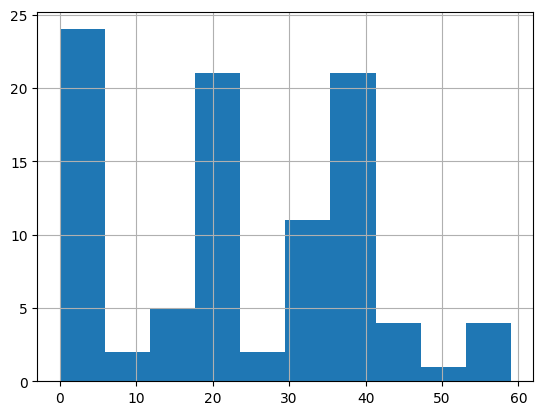

In [63]:
# Check distribution of age
df['person_age'].hist()

In [64]:
# Set age of 0 to NA
import numpy as np

df['person_age'] = df['person_age'].replace(0, np.nan)

In [65]:
### Sex Column

<Axes: xlabel='person_sex'>

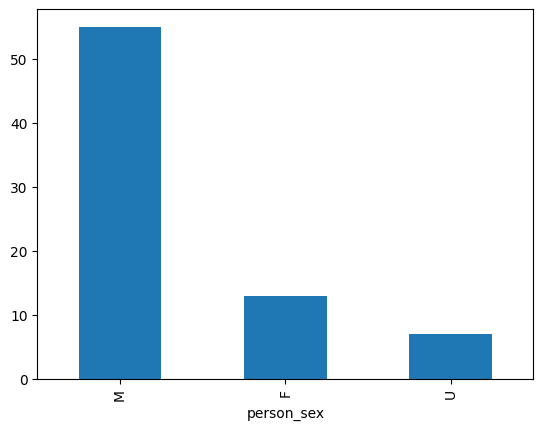

In [66]:
# Plot groups and frequency of sex column
df['person_sex'].value_counts().plot(kind='bar')

In [67]:
# Check NA values
df['person_sex'].isna().sum()

20

Car column

In [68]:
import os
from src.embeddings.car_make import CarMakeEmbedding

cme = CarMakeEmbedding(
    label_encoder=r"..\..\..\data\models\encoder.pkl",
    pkl_path=r"..\..\..\data\models\embedding.pkl",
)


C:\Users\ferra\PycharmProjects\adsdb-project\src\embeddings\car_make.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.embedding.load_state_dict(torch.load(pkl_path)

In [69]:
import pandas as pd

df["vehicle_make_embedding"] = df["vehicle_make"].apply(lambda x: cme.execute(x)[0])
make_df = pd.DataFrame(
    df["vehicle_make_embedding"].tolist(),
    columns=[f"make_{i}" for i in range(len(df["vehicle_make_embedding"][0]))],
)
df = pd.concat([df.drop(columns=["vehicle_make_embedding"]), make_df], axis=1)
df.dropna(inplace=True)

In [70]:
df.head()

,person_age,person_sex,vehicle_make,overall_rating,vehicle_age,make_0,make_1,make_2,make_3,make_4,make_5,make_6,make_7,make_8,make_9
0,22.0,M,ford,4.246416,9.0,1.271948,-1.854546,0.256751,1.405547,-0.127058,-0.490746,-0.513944,-0.049678,0.977539,0.895555
1,16.0,F,honda,4.000000,8.0,1.079697,1.275756,-2.120022,0.443211,-0.032822,-1.873419,0.642528,1.523962,1.413312,0.522230
4,36.0,M,ford,3.000000,8.0,1.271948,-1.854546,0.256751,1.405547,-0.127058,-0.490746,-0.513944,-0.049678,0.977539,0.895555
6,7.0,F,honda,4.000000,8.0,1.079697,1.275756,-2.120022,0.443211,-0.032822,-1.873419,0.642528,1.523962,1.413312,0.522230
7,31.0,M,ford,4.500000,9.0,1.271948,-1.854546,0.256751,1.405547,-0.127058,-0.490746,-0.513944,-0.049678,0.977539,0.895555


In [71]:
df.drop(columns=['vehicle_make'], inplace=True)

### Vehicle rating



<Axes: >

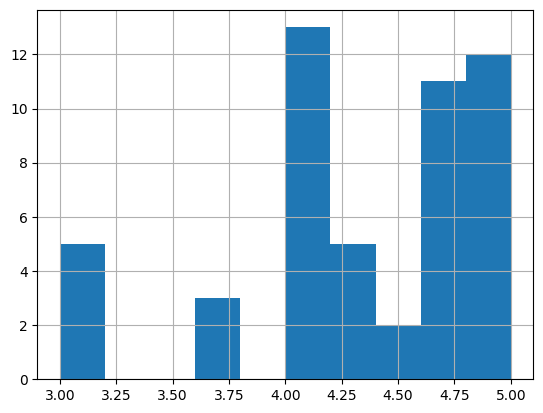

In [73]:
df['overall_rating'].hist()

In [74]:
df['overall_rating'] = df['overall_rating'].clip(lower=0, upper=5)
df['overall_rating'] = np.round(df['overall_rating'] * 2) / 2

<Axes: xlabel='overall_rating'>

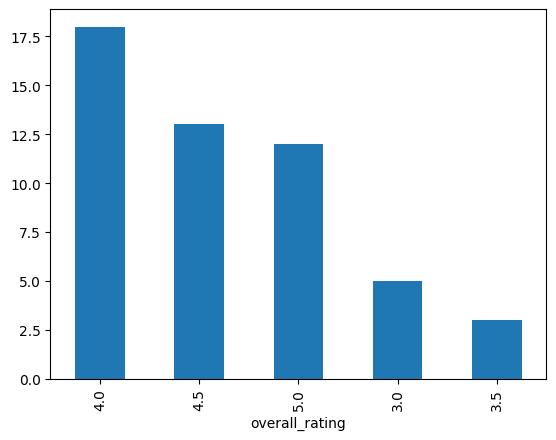

In [76]:
df['overall_rating'].value_counts().plot(kind='bar')

In [77]:
df.head()

,person_age,person_sex,overall_rating,vehicle_age,make_0,make_1,make_2,make_3,make_4,make_5,make_6,make_7,make_8,make_9
0,22.0,M,4.0,9.0,1.271948,-1.854546,0.256751,1.405547,-0.127058,-0.490746,-0.513944,-0.049678,0.977539,0.895555
1,16.0,F,4.0,8.0,1.079697,1.275756,-2.120022,0.443211,-0.032822,-1.873419,0.642528,1.523962,1.413312,0.522230
4,36.0,M,3.0,8.0,1.271948,-1.854546,0.256751,1.405547,-0.127058,-0.490746,-0.513944,-0.049678,0.977539,0.895555
6,7.0,F,4.0,8.0,1.079697,1.275756,-2.120022,0.443211,-0.032822,-1.873419,0.642528,1.523962,1.413312,0.522230
7,31.0,M,4.5,9.0,1.271948,-1.854546,0.256751,1.405547,-0.127058,-0.490746,-0.513944,-0.049678,0.977539,0.895555
